## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

In [35]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.pyplot as plt

from sklearn.utils.extmath import softmax
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_X_y, column_or_1d
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, is_classifier, is_regressor

from abc import ABCMeta, abstractmethod
from pysim.aspline import ASplineClassifier, ASplineRegressor

from rpy2 import robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

utils = importr("utils")
utils.install_packages("fps")

fps = importr("fps")
numpy2ri.activate()


class BaseSim(BaseEstimator, metaclass=ABCMeta):
    """
        Base class for sim classification and regression.
     """

    @abstractmethod
    def __init__(self, method="first_order", reg_lambda=0.1, reg_gamma=10, 
                 knot_num=20, degree=2, random_state=0):

        self.method = method
        self.reg_lambda = reg_lambda
        self.reg_gamma = reg_gamma
        self.knot_num = knot_num
        self.degree = degree
        
        self.random_state = random_state

    def _validate_hyperparameters(self):
        
        if self.method not in ["first_order", "second_order", "first_order_thres"]:
            raise ValueError("method must be an element of [first_order, second_order, first_order_thres], got %s." % self.method)
                
        if not isinstance(self.degree, int):
            raise ValueError("degree must be an integer, got %s." % self.degree)

        if self.degree < 0:
            raise ValueError("degree must be >= 0, got" % self.degree)
        
        if not isinstance(self.knot_num, int):
            raise ValueError("knot_num must be an integer, got %s." % self.knot_num)

        if self.knot_num <= 0:
            raise ValueError("knot_num must be > 0, got" % self.knot_num)

        if self.reg_lambda < 0:
            raise ValueError("reg_lambda must be >= 0, got %s." % self.reg_lambda)

        if self.reg_gamma < 0:
            raise ValueError("reg_gamma must be >= 0, got %s." % self.reg_gamma)

    def _validate_sample_weight(self, n_samples, sample_weight):
        
        if sample_weight is None:
            sample_weight = np.ones(n_samples) / n_samples
        else:
            sample_weight = sample_weight / np.sum(sample_weight)
        return sample_weight

    def _first_order_thres(self, x, y, sample_weight=None, proj_mat=None):

        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        zbar = np.average(y.reshape(-1, 1) * s1, axis=0, weights=sample_weight)
        if np.all(np.abs(zbar) < self.reg_lambda * np.sum(np.abs(zbar))):
            zbar[np.abs(zbar) < np.max(np.abs(zbar))] = 0
        else:
            zbar[np.abs(zbar) < self.reg_lambda * np.sum(np.abs(zbar))] = 0
        if proj_mat is not None:
            zbar = np.dot(proj_mat, zbar)
        if np.linalg.norm(zbar) > 0:
            beta = zbar / np.linalg.norm(zbar)
        else:
            beta = zbar
        return beta.reshape([-1, 1])

    def _first_order(self, x, y, sample_weight=None, proj_mat=None):

        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        zbar = np.average(y.reshape(-1, 1) * s1, axis=0, weights=sample_weight)
        sigmat = np.dot(zbar.reshape([-1, 1]), zbar.reshape([-1, 1]).T)
        if proj_mat is not None:
            sigmat = np.dot(np.dot(proj_mat, sigmat), proj_mat)
        u, s, v = np.linalg.svd(sigmat)
        sigmat = np.dot(np.dot(u, np.diag(s)), u.T)
        
        spca_solver = fps.fps(sigmat, 1, 1, -1, -1, ro.r.c(self.reg_lambda * np.sum(np.abs(zbar))))
        beta = np.array(fps.coef_fps(spca_solver, self.reg_lambda * np.sum(np.abs(zbar))))
        return beta

    def _second_order(self, x, y, sample_weight=None, proj_mat=None):

        n_samples, n_features = x.shape
        self.mu = np.average(x, axis=0, weights=sample_weight) 
        self.cov = np.cov(x.T, aweights=sample_weight)
        self.inv_cov = np.linalg.pinv(self.cov)
        s1 = np.dot(self.inv_cov, (x - self.mu).T).T
        sigmat = np.tensordot(s1 * y.reshape([-1, 1]) * sample_weight.reshape([-1, 1]), s1, axes=([0], [0]))
        sigmat -= np.average(y, axis=0, weights=sample_weight) * self.inv_cov
        if proj_mat is not None:
            sigmat = np.dot(np.dot(proj_mat, sigmat), proj_mat)
        u, s, v = np.linalg.svd(sigmat)
        sigmat = np.dot(np.dot(u, np.diag(s)), u.T)

        beta_svd_l1norm = np.sum(np.abs(np.linalg.svd(sigmat)[0][:, 0]))  
        spca_solver = fps.fps(sigmat, 1, 1, -1, -1, ro.r.c(self.reg_lambda * beta_svd_l1norm))
        beta = np.array(fps.coef_fps(spca_solver, self.reg_lambda * np.sum(np.abs(beta_svd_l1norm))))
        return beta

    def visualize(self):

        check_is_fitted(self, "beta_")
        check_is_fitted(self, "shape_fit_")

        xlim_min = - max(np.abs(self.beta_.min() - 0.1), np.abs(self.beta_.max() + 0.1))
        xlim_max = max(np.abs(self.beta_.min() - 0.1), np.abs(self.beta_.max() + 0.1))

        fig = plt.figure(figsize=(12, 4))
        outer = gridspec.GridSpec(1, 2, wspace=0.15)      
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1, height_ratios=[6, 1])
        ax1_main = plt.Subplot(fig, inner[0]) 
        xgrid = np.linspace(self.shape_fit_.xmin, self.shape_fit_.xmax, 100).reshape([-1, 1])
        ygrid = self.shape_fit_.decision_function(xgrid)
        ax1_main.plot(xgrid, ygrid)
        ax1_main.set_xticklabels([])
        ax1_main.set_title("Shape Function", fontsize=12)
        fig.add_subplot(ax1_main)
        
        ax1_density = plt.Subplot(fig, inner[1]) 
        xint = ((np.array(self.shape_fit_.bins_[1:]) + np.array(self.shape_fit_.bins_[:-1])) / 2).reshape([-1, 1]).reshape([-1])
        ax1_density.bar(xint, self.shape_fit_.density_, width=xint[1] - xint[0])
        ax1_main.get_shared_x_axes().join(ax1_main, ax1_density)
        ax1_density.set_yticklabels([])
        ax1_density.autoscale()
        fig.add_subplot(ax1_density)

        ax2 = plt.Subplot(fig, outer[1]) 
        if len(self.beta_) <= 10:
            rects = ax2.barh(np.arange(len(self.beta_)), [beta for beta in self.beta_.ravel()][::-1])
            ax2.set_yticks(np.arange(len(self.beta_)))
            ax2.set_yticklabels(["X" + str(idx + 1) for idx in range(len(self.beta_.ravel()))][::-1])
            ax2.set_xlim(xlim_min, xlim_max)
            ax2.set_ylim(-1, len(self.beta_))
            ax2.axvline(0, linestyle="dotted", color="black")
        else:
            active_beta = []
            active_beta_idx = []
            for idx, beta in enumerate(self.beta_.ravel()):
                if np.abs(beta) > 0:
                    active_beta.append(beta)
                    active_beta_idx.append(idx)
            rects = ax2.barh(np.arange(len(active_beta)), [beta for beta in active_beta][::-1])
            ax2.set_yticks(np.arange(len(active_beta)))
            ax2.set_yticklabels(["X" + str(idx + 1) for idx in active_beta_idx][::-1])
            ax2.set_xlim(xlim_min, xlim_max)
            ax2.set_ylim(-1, len(active_beta_idx))
            ax2.axvline(0, linestyle="dotted", color="black")
        ax2.set_title("Projection Indice", fontsize=12)
        fig.add_subplot(ax2)
        plt.show()
    
    def fit_inner_update(self, x, y, sample_weight=None, max_inner_iter=10, epoches=100, n_iter_no_change=100,
                         batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=False):
        
        x, y = self._validate_input(x, y)
        n_samples = x.shape[0]
        sample_weight = self._validate_sample_weight(n_samples, sample_weight)

        idx1, idx2 = train_test_split(np.arange(n_samples),test_size=val_ratio, random_state=self.random_state)
        tr_x, tr_y, val_x, val_y = x[idx1], y[idx1], x[idx2], y[idx2]

        for inner_iter in range(max_inner_iter):

            m_t = 0 # moving average of the gradient
            v_t = 0 # moving average of the gradient square
            no_change = 0
            num_updates = 0
            theta_0 = self.beta_ 
            val_loss_best = np.inf
            train_size = tr_x.shape[0]
            for epoch in range(epoches):

                shuffle_index = np.arange(tr_x.shape[0])
                np.random.shuffle(shuffle_index)
                tr_x = tr_x[shuffle_index]
                tr_y = tr_y[shuffle_index]

                for iterations in range(train_size // batch_size):

                    num_updates += 1
                    offset = (iterations * batch_size) % train_size
                    batch_xx = tr_x[offset:(offset + batch_size), :]
                    batch_yy = tr_y[offset:(offset + batch_size)]
                    batch_sample_weight = sample_weight[offset:(offset + batch_size)]

                    xb = np.dot(batch_xx, theta_0)
                    if is_regressor(self):
                        r = batch_yy - self.shape_fit_.predict(xb)
                    elif is_classifier(self):
                        r = batch_yy - self.shape_fit_.predict_proba(xb)
                    
                    # gradient
                    dfxb = clf.shape_fit_.diff(xb, order=1)
                    g_t = np.average((- dfxb * r).reshape(-1, 1) * batch_xx, axis=0,
                                     weights=batch_sample_weight).reshape(-1, 1)

                    # update the moving average 
                    m_t = beta_1 * m_t + (1 - beta_1) * g_t
                    v_t = beta_2 * v_t + (1 - beta_2) * (g_t * g_t)
                    # calculates the bias-corrected estimates
                    m_cap = m_t / (1 - (beta_1 ** (num_updates + 1)))  
                    v_cap = v_t / (1 - (beta_2 ** (num_updates + 1)))
                    # updates the parameters
                    theta_0 = theta_0 - (learning_rate * m_cap) / (np.sqrt(v_cap) + 1e-8)

                # validation loss
                val_xb = np.dot(val_x, theta_0)
                if is_regressor(self):
                    val_r = val_y - self.shape_fit_.predict(val_xb)
                    val_loss = np.average(val_r ** 2, axis=0, weights=sample_weight[idx2])
                elif is_classifier(self):
                    val_p = self.shape_fit_.predict_proba(val_xb)
                    val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
                                          axis=0, weights=sample_weight[idx2])
                
                # stop criterion
                if np.abs(val_loss_best - val_loss) > 0.0001:
                    val_loss_best = val_loss
                    no_change = 0
                else:
                    no_change += 1
                if no_change >= n_iter_no_change:
                    break
                if verbose:
                    print("Inner iter:", inner_iter, "epoch:", epoch, "with validation loss:", np.round(val_loss, 5))
  
            ## thresholding and normalization
            theta_0 = np.sign(theta_0) * np.maximum(np.abs(theta_0) - clf.reg_lambda * np.sum(np.abs(theta_0)), 0)
            theta_0 = theta_0 / np.linalg.norm(theta_0) 
    
            if len(theta_0[np.abs(theta_0) > 0]) > 0:
                if (theta_0[np.abs(theta_0) > 0][0] < 0):
                    theta_0 = - theta_0

            # ridge update
            self.beta_ = theta_0
            xb = np.dot(x, self.beta_)
            self._estimate_shape(xb, y, sample_weight, xmin=np.min(xb), xmax=np.max(xb))

    def fit(self, x, y, sample_weight=None, proj_mat=None):

        np.random.seed(self.random_state)
        
        self._validate_hyperparameters()
        x, y = self._validate_input(x, y)
        n_samples, n_features = x.shape
        if sample_weight is None:
            sample_weight = np.ones(n_samples) / n_samples
        else:
            sample_weight = sample_weight / np.sum(sample_weight)
        
        if self.method == "first_order":
            self.beta_ = self._first_order(x, y, sample_weight, proj_mat)
        elif self.method == "first_order_thres":
            self.beta_ = self._first_order_thres(x, y, sample_weight, proj_mat)
        elif self.method == "second_order":
            self.beta_ = self._second_order(x, y, sample_weight, proj_mat)

        if len(self.beta_[np.abs(self.beta_) > 0]) > 0:
            if (self.beta_[np.abs(self.beta_) > 0][0] < 0):
                self.beta_ = - self.beta_
        xb = np.dot(x, self.beta_)
        self._estimate_shape(xb, y, sample_weight, xmin=np.min(xb), xmax=np.max(xb))
        return self

    def decision_function(self, x):

        check_is_fitted(self, "beta_")
        check_is_fitted(self, "shape_fit_")
        xb = np.dot(x, self.beta_)
        pred = self.shape_fit_.decision_function(xb)
        return pred


class SimRegressor(BaseSim, RegressorMixin):

    def __init__(self, method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0):

        super(SimRegressor, self).__init__(method=method,
                                reg_lambda=reg_lambda,
                                reg_gamma=reg_gamma,
                                knot_num=knot_num,
                                degree=degree,
                                random_state=random_state)

    def _validate_input(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=["csr", "csc", "coo"],
                         multi_output=True, y_numeric=True)
        return x, y

    def _estimate_shape(self, x, y, sample_weight=None, xmin=-1, xmax=1):

        self.shape_fit_ = ASplineRegressor(knot_num=self.knot_num, reg_gamma=self.reg_gamma,
                             xmin=xmin, xmax=xmax, degree=self.degree)
        self.shape_fit_.fit(x, y, sample_weight)

    def predict(self, x):

        pred = self.decision_function(x)
        return pred
    

class SimClassifier(BaseSim, ClassifierMixin):

    def __init__(self, method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0):

        super(SimClassifier, self).__init__(method=method,
                                reg_lambda=reg_lambda,
                                reg_gamma=reg_gamma,
                                knot_num=knot_num,
                                degree=degree,
                                random_state=random_state)

    def _validate_input(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=["csr", "csc", "coo"],
                         multi_output=True)
        if y.ndim == 2 and y.shape[1] == 1:
            y = column_or_1d(y, warn=False)

        self._label_binarizer = LabelBinarizer()
        self._label_binarizer.fit(y)
        self.classes_ = self._label_binarizer.classes_

        y = self._label_binarizer.transform(y) * 1.0
        return x, y.ravel()

    def _estimate_shape(self, x, y, sample_weight=None, xmin=-1, xmax=1):

        #adaptive spline
        self.shape_fit_ = ASplineClassifier(knot_num=self.knot_num, reg_gamma=self.reg_gamma,
                         xmin=xmin, xmax=xmax, degree=self.degree)
        self.shape_fit_.fit(x, y, sample_weight)

    def predict_proba(self, x):

        pred = self.decision_function(x)
        pred_proba = softmax(np.vstack([-pred, pred]).T / 2, copy=False)[:, 1]
        return pred_proba

    def predict(self, x):

        pred_proba = self.predict_proba(x)
        return self._label_binarizer.inverse_transform(pred_proba)

In [36]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

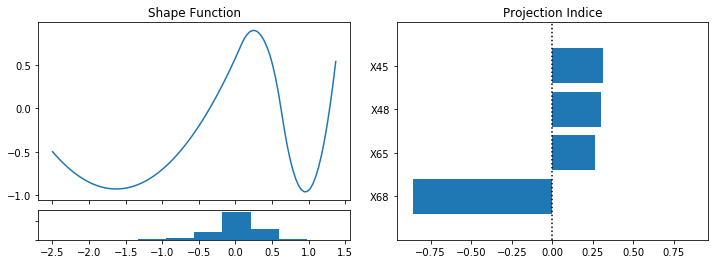

CPU times: user 4.62 s, sys: 10 s, total: 14.7 s
Wall time: 624 ms


In [37]:
%%time

clf = SimRegressor(method="first_order", degree=2, knot_num=20, reg_gamma=1.0, reg_lambda=0.01, random_state=0)
clf.fit(x, y)
clf.visualize()

In [38]:
np.mean((y - clf.predict(x)) ** 2)

0.06188534134149346

In [39]:
clf.fit_inner_update(x, y, max_inner_iter=10, epoches=10, n_iter_no_change=1,
                     batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=True)

Inner iter: 0 epoch: 0 with validation loss: 0.04888
Inner iter: 0 epoch: 1 with validation loss: 0.04209
Inner iter: 0 epoch: 2 with validation loss: 0.03932
Inner iter: 0 epoch: 3 with validation loss: 0.03795
Inner iter: 0 epoch: 4 with validation loss: 0.03764
Inner iter: 0 epoch: 5 with validation loss: 0.03725
Inner iter: 0 epoch: 6 with validation loss: 0.03708
Inner iter: 0 epoch: 7 with validation loss: 0.0376
Inner iter: 0 epoch: 8 with validation loss: 0.03697
Inner iter: 1 epoch: 0 with validation loss: 0.01615
Inner iter: 1 epoch: 1 with validation loss: 0.01522
Inner iter: 1 epoch: 2 with validation loss: 0.01491
Inner iter: 2 epoch: 0 with validation loss: 0.01143
Inner iter: 2 epoch: 1 with validation loss: 0.01188
Inner iter: 2 epoch: 2 with validation loss: 0.01141
Inner iter: 2 epoch: 3 with validation loss: 0.01165
Inner iter: 2 epoch: 4 with validation loss: 0.0118
Inner iter: 2 epoch: 5 with validation loss: 0.01139
Inner iter: 3 epoch: 0 with validation loss: 0.0

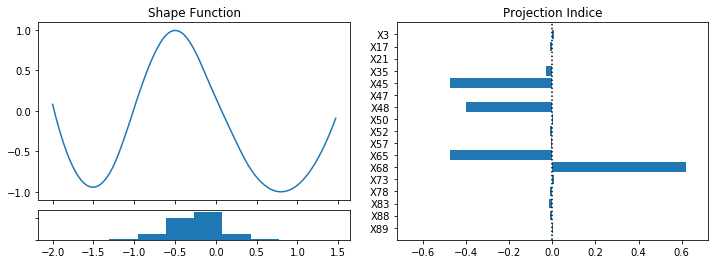

In [18]:
clf.visualize()

In [19]:
np.mean((y - clf.predict(x)) ** 2)

0.01785355025455788

In [20]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.05 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

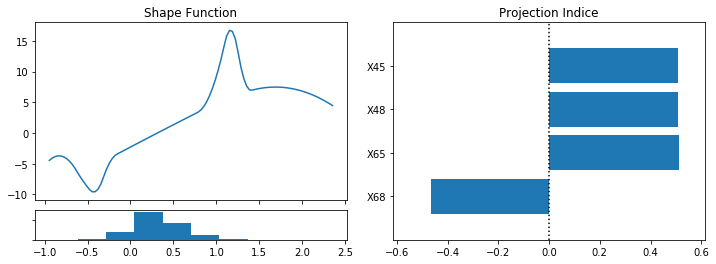

CPU times: user 6.29 s, sys: 13.4 s, total: 19.7 s
Wall time: 652 ms


In [21]:
%%time

clf = SimClassifier(method="first_order", degree=2, knot_num=20, reg_gamma=1.0, reg_lambda=0.01, random_state=0)
clf.fit(x, y)
clf.visualize()

In [22]:
roc_auc_score(y, clf.predict_proba(x))

0.8614291775616122

In [23]:
clf.fit_inner_update(x, y, max_inner_iter=10, epoches=10, n_iter_no_change=1,
                     batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=True)

KeyboardInterrupt: 

In [ ]:
clf.visualize()

In [ ]:
roc_auc_score(y, clf.predict_proba(x))